In [415]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [416]:
# read the img
img=cv2.imread('original_retinal_images/IDRiD_01.jpg')

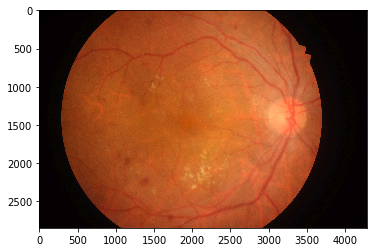

In [417]:
# use matplotlib.pyplot to show the gray level img
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [418]:
print(img.shape,img.size)


(2848, 4288, 3) 36636672


In [419]:
# preprocessing

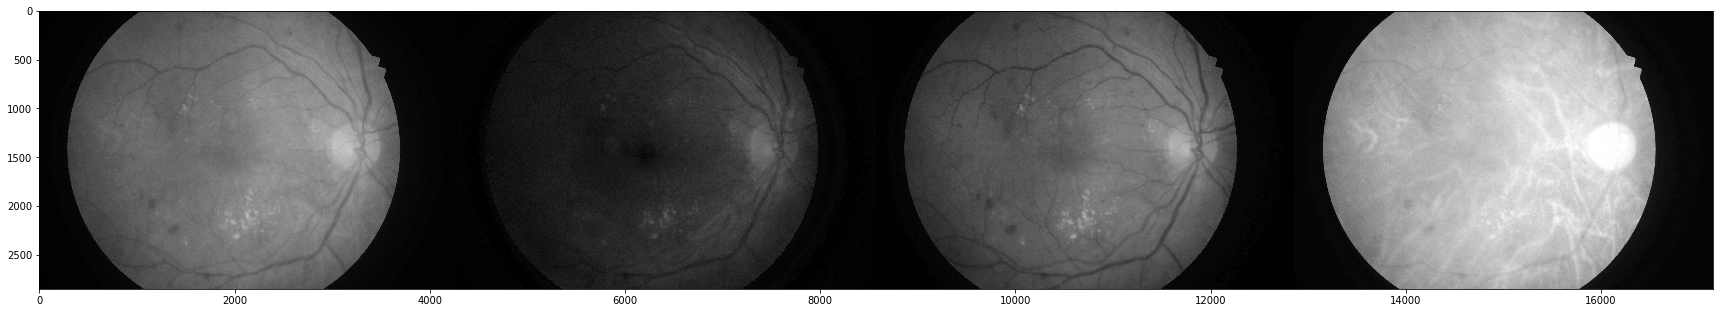

In [420]:
plt.figure(figsize=(30,18)) 
#A. RetinalImagePre-processing
# Red layer extraction
# split img color channel to B,G,R
b,g,r = cv2.split(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# use matplotlib.pyplot to show the gray level img
imgs = np.hstack((gray,b,g,r))
plt.imshow(imgs,'gray')

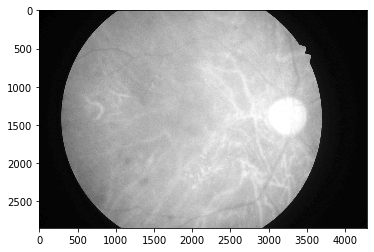

In [421]:
plt.imshow(r,'gray')

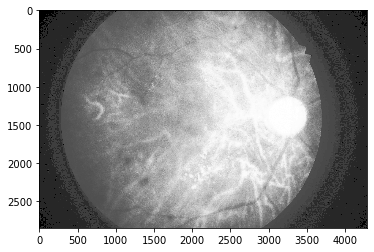

In [422]:
# GLOBAL CLAHE
equ = cv2.equalizeHist(r)
plt.imshow(equ,'gray')

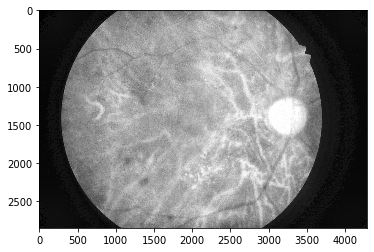

In [423]:
# Adaptive histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    # adaptive
cl1 = clahe.apply(r)
plt.imshow(cl1, 'gray')

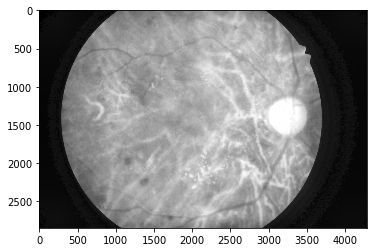

In [424]:
# median filter
median = cv2.medianBlur(cl1, 15)    # adaptive
plt.imshow(median, 'gray')

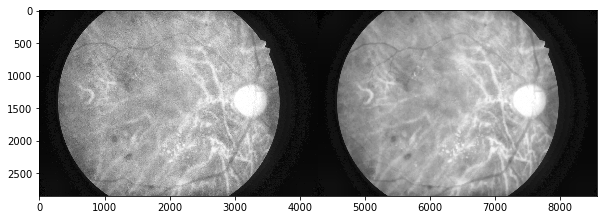

In [425]:
plt.figure(figsize=(10,6)) 
p1=np.hstack((cl1,median))
plt.imshow(p1,'gray')

(89, 134) (1, 11926)


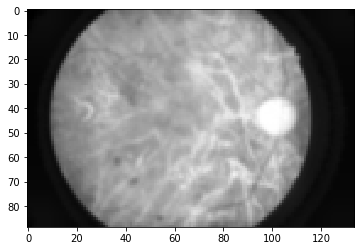

In [426]:
# processing
# down sampling
down0=cv2.pyrDown(median)
down1=cv2.pyrDown(down0)
down2=cv2.pyrDown(down1)
down3=cv2.pyrDown(down2)
down4=cv2.pyrDown(down3)

plt.imshow(down4, 'gray')

down4_shape = down4.shape
down4_ravel = down4.reshape([1, -1])
print(down4_shape, down4_ravel.shape)

In [427]:
# B. Fuzzyc-meansBinarization
import skfuzzy as fuzz
ncenters = 25   # 25 classifier
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    down4_ravel, ncenters, 2, error=0.005, maxiter=1000)

In [428]:
# u 竖着有25行，11926列。哪一行的数值最大，这一列就属于第几类
cntr.shape, u.shape

((25, 1), (25, 11926))

In [429]:
u[0], u[24]

(array([5.57638894e-04, 5.57638894e-04, 5.57638894e-04, ...,
        3.35487821e-05, 4.62987408e-07, 4.62987408e-07]),
 array([7.79739261e-04, 7.79739261e-04, 7.79739261e-04, ...,
        4.79946912e-05, 6.60743705e-07, 6.60743705e-07]))

In [430]:
cntr

array([[173.701373  ],
       [251.9517973 ],
       [130.44247407],
       [ 11.88982147],
       [214.00943888],
       [167.64547029],
       [180.66294525],
       [109.21332667],
       [203.69129877],
       [187.76736773],
       [154.98017768],
       [225.28703766],
       [ 50.98143671],
       [195.15230871],
       [ 24.54822873],
       [ 34.30334919],
       [121.08400033],
       [138.92207324],
       [  8.50058872],
       [ 15.02047479],
       [ 71.46579275],
       [ 94.31267925],
       [161.3441292 ],
       [ 18.20560742],
       [147.35733032]])

In [431]:
# find the level/classifier of the brightest area.
max_c = np.argmax(cntr, axis=0)
max_c

array([1])

In [432]:
# u有25行(类)，11926列(点)。这一列（点）在哪一行的数值最大，这一列（点）就属于第几类
cluster_membership = np.argmax(u, axis=0)
# the array of clusters
cluster_membership

array([18, 18, 18, ...,  3,  3,  3])

In [433]:
# array of combination of pixels and corresponding clusters 
a=np.array([down4_ravel,cluster_membership])
a

array([array([[ 3,  3,  3, ..., 13, 12, 12]], dtype=uint8),
       array([18, 18, 18, ...,  3,  3,  3])], dtype=object)

In [434]:
# if is not the brightest area, ouput 0
x=np.where(a[1]==max_c, a[0], 0)

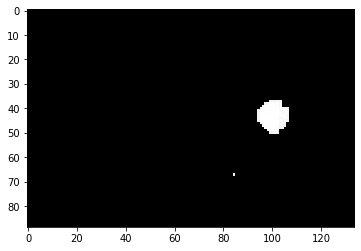

In [487]:
down4_new = x.reshape(down4_shape)
plt.imshow(down4_new, 'gray')

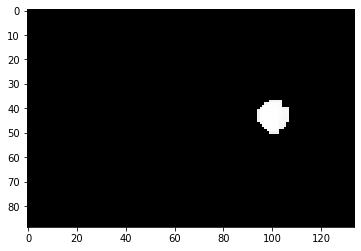

In [488]:
# Morphological opening followed by dilation removes the objects
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(down4_new, cv2.MORPH_OPEN, kernel)
plt.imshow(opening, 'gray')

In [489]:
# # no need
# # dilation
# kernel = np.ones((3, 3), np.uint8)
# opening = cv2.dilate(opening,kernel,iterations = 1)
# plt.imshow(opening, 'gray')

(2848, 4288)

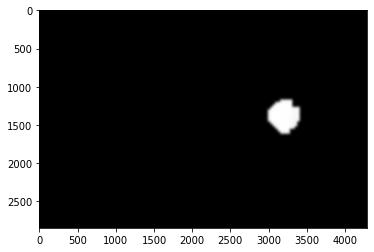

In [490]:
# become to original size
up0=cv2.pyrUp(opening)
up1=cv2.pyrUp(up0)
up2=cv2.pyrUp(up1)
up3=cv2.pyrUp(up2)
up4=cv2.pyrUp(up3)
plt.imshow(up4, 'gray')
up4.shape

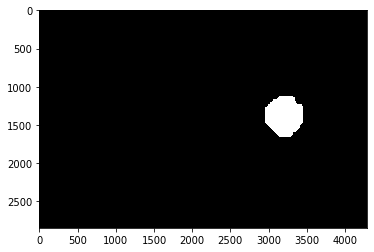

In [491]:
# plt.imshow(opening, 'gray')
res, threshold = cv2.threshold(up4,0,255,cv2.THRESH_BINARY)
plt.imshow(threshold, 'gray')

In [492]:
Counter(threshold.flatten())

Counter({0: 12003193, 255: 209031})

(2848, 4288, 3)


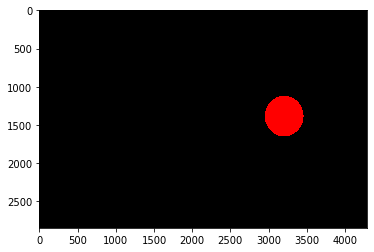

In [493]:
# Contour detection
binary, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
threshold_copy = threshold.copy()
# GRAY TO rgb
color_channel = np.zeros(threshold.shape, np.uint8)
threshold_copy = cv2.merge((threshold_copy, threshold_copy, threshold_copy))
# res = cv2.drawContours(up4_copy, contours, -1, (0,0,255), 2)
mask1 = np.zeros(threshold_copy.shape, dtype="uint8")
# Ellipse fitting
cnt = contours[0]
ellipse = cv2.fitEllipse(cnt)
res = cv2.ellipse(mask1, ellipse, (255, 0, 0), cv2.FILLED)
print(res.shape)
plt.imshow(res)

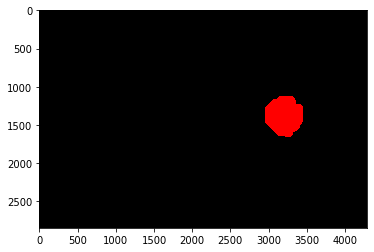

In [494]:
# Contour approximately detection
mask2 = np.zeros(threshold_copy.shape, dtype="uint8")
epsilon = 0.005*cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt,epsilon,True)
res2 = cv2.drawContours(mask2,[approx], -1, (255,0,0), cv2.FILLED)
plt.imshow(res2)

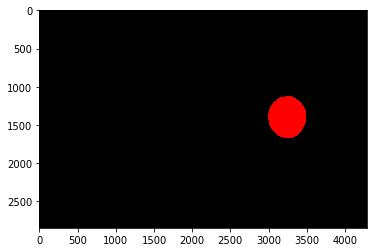

In [495]:
true=cv2.imread('optic_disc_segmentation_masks/IDRiD_01_OD.tif')
plt.imshow(cv2.cvtColor(true, cv2.COLOR_BGR2RGB))

In [496]:
def dice_loss(res, true):
    res_g = cv2.cvtColor(res,cv2.COLOR_RGB2GRAY)
    true_g = cv2.cvtColor(true,cv2.COLOR_BGR2GRAY)
    acc = cv2.bitwise_xor(res_g,true_g)
    acc = cv2.bitwise_not(acc)
    plt.imshow(acc,'gray')
    print("Accuracy: ", np.bincount(acc.flatten())[255]/acc.size)

Accuracy:  0.996192503511236


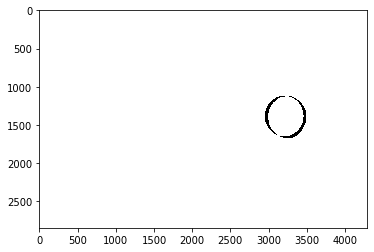

In [499]:
dice_loss(res, true)

Accuracy:  0.9963561100746269


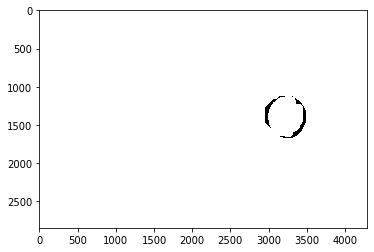

In [500]:
dice_loss(res2, true)